In [55]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [70]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx
import yfinance as yfin
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [85]:
df = yfin.download(tickers=['IBM'], period='6mo')
dataset = df['Close'].fillna(method='ffill')
dataset = dataset.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_127/3481568464.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = df['Close'].fillna(method='ffill')


In [86]:
dataset.shape

(127, 1)

In [87]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(dataset)
dataset = scaler.transform(dataset)

In [88]:
# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(dataset) - n_forecast + 1):
    X.append(dataset[i - n_lookback: i])
    Y.append(dataset[i: i + n_forecast])

In [89]:
X = np.array(X)
Y = np.array(Y)


In [90]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

In [91]:

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

In [92]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 0s 424ms/step


In [93]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

/tmp/ipykernel_127/3704570742.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
/tmp/ipykernel_127/3704570742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [94]:

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

<Axes: title={'center': 'IBM'}, xlabel='Date'>

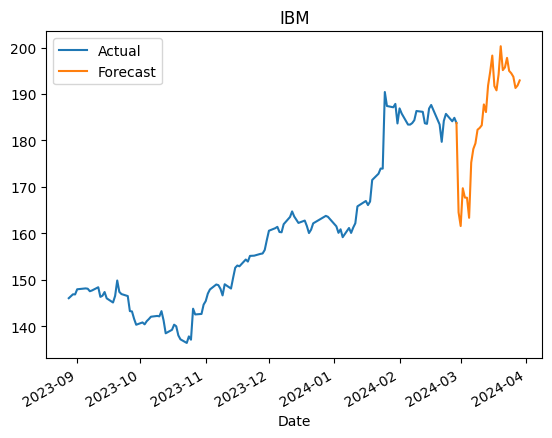

In [95]:
results = pd.concat([df_past, df_future])
results = results.set_index('Date')

# plot the results
results.plot(title='IBM')


In [96]:
model.save("./future_trend.keras")

In [97]:
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, "./future_trend.onnx")

2024-02-28 15:50:20.431847: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-28 15:50:20.431986: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-28 15:50:20.532349: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-28 15:50:20.532458: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
